## 201710812 한우정

## 문제1: 2020년 8월 서울시 지하철호선별 역별 승하차 인원 정보

In [1]:
#create spark
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

### 답 1. DataFrame 생성하고, 스키마는 자동인식하여 출력

In [2]:
#1.
import os
#create DatFrame
sub_df = spark.read\
        .options(header ='true', inferschema ='true', delimiter=',')\
        .csv(os.path.join('data','CARD_SUBWAY_MONTH_202008.csv'))

#sub_df.show()
sub_df.printSchema()

root
 |-- 사용일자: integer (nullable = true)
 |-- 노선명: string (nullable = true)
 |-- 역ID: string (nullable = true)
 |-- 역명: integer (nullable = true)
 |-- 승차총승객수: integer (nullable = true)
 |-- 하차총승객수: integer (nullable = true)
 |-- 등록일자: string (nullable = true)



### 답 2. 컬럼명을 변경하고, 스키마 출력

In [3]:
#2.
#Rename Column name
sub_df=sub_df.withColumnRenamed('사용일자','dateUse')\
    .withColumnRenamed('노선명','line')\
    .withColumnRenamed('역ID','stationID')\
    .withColumnRenamed('역명','station')\
    .withColumnRenamed('승차총승객수','NInPassengers')\
    .withColumnRenamed('하차총승객수','NOutPassengers')\
    .withColumnRenamed('등록일자','dateRegi')

sub_df.printSchema()

root
 |-- dateUse: integer (nullable = true)
 |-- line: string (nullable = true)
 |-- stationID: string (nullable = true)
 |-- station: integer (nullable = true)
 |-- NInPassengers: integer (nullable = true)
 |-- NOutPassengers: integer (nullable = true)
 |-- dateRegi: string (nullable = true)



### 답 3. 노선별 승하차합계가 가장 높은 역을 출력 (모든 노선 출력)

In [4]:
#3. 
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from datetime import datetime
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import rank

#dateUse integer to string
sub_df = sub_df.withColumn("dateUse1", sub_df.dateUse.cast("string"))

#add Date Column using "dateUse1"
toDate = udf(lambda x: datetime.strptime(x, '%Y%m%d'), DateType())
sub_df = sub_df.withColumn('Date', toDate(sub_df['dateUse1']))

#drop dateUse1
sub_df = sub_df.drop('dateUse1')


#add SumInOut Column
sub_df=sub_df.withColumn('SumInOut',(sub_df['NInPassengers']+sub_df['NOutPassengers']).cast(IntegerType()))

#using window Function to calculate high rate of Passenger
winF = Window.partitionBy("line").orderBy(F.col("SumInOut").desc())
high_pass=sub_df.withColumn("rank", rank().over(winF))
high_pass=high_pass.filter(high_pass['rank']==1)
high_pass=high_pass.drop('rank')
high_pass.show(25)

+--------+--------------+--------------------+-------+-------------+--------------+--------+----------+--------+
| dateUse|          line|           stationID|station|NInPassengers|NOutPassengers|dateRegi|      Date|SumInOut|
+--------+--------------+--------------------+-------+-------------+--------------+--------+----------+--------+
|20200807|        일산선|                화정|  17591|        17916|      20200810|    null|2020-08-07|20218726|
|20200814|        장항선|            온양온천|   4528|         4534|      20200817|    null|2020-08-14|20205351|
|20200807|        경부선|              영등포|  43168|        46982|      20200810|    null|2020-08-07|20247792|
|20200812|    우이신설선|        북한산보국문|   5432|         5200|      20200815|    null|2020-08-12|20206015|
|20200814|        분당선|                야탑|  25876|        27587|      20200817|    null|2020-08-14|20228404|
|20200812|         7호선|      가산디지털단지|  46117|        46836|      20200815|    null|2020-08-12|20247651|
|20200812|        수인선|    

### 답 4. 노선별 요일별 승하차인원 합계 (모든 노선 출력)

In [5]:
#4.
#date(요일)
def date(s):
    q=""
    if s%7 == 3 :
        q="Monday"
    elif  s%7 == 4:
        q="Tuesday"
    elif  s%7 == 5:
        q="Wednesday"
    elif  s%7 == 6:
        q="Thursday"
    elif  s%7 == 0:
        q="Friday"
    elif s%7 == 1:
        q="Saturday"
    else:
        q="Sunday"
    return q
date_udf = udf(date, StringType())

#add date column
sub_df_date=sub_df.withColumn("dates",sub_df['dateUse'].substr(7,2).cast("integer"))
sub_df_date=sub_df_date.withColumn("date", date_udf(sub_df_date.dates))

#date and lines
maplines=sub_df_date.groupBy('line').pivot('date').agg({"SumInOut":"sum"})
maplines.show(25)

+--------------+----------+----------+----------+----------+----------+----------+----------+
|          line|    Friday|    Monday|  Saturday|    Sunday|  Thursday|   Tuesday| Wednesday|
+--------------+----------+----------+----------+----------+----------+----------+----------+
|        일산선| 808395124|1010437381|1010319451|1010235636| 808383940| 808393127| 808392796|
|        장항선| 484860929| 606069487| 606063946| 606058420| 484854907| 484857571| 484857468|
|        경부선|3152874143|3940824196|3940449561|3940133615|3152768029|3152789327|3152794978|
|    우이신설선|1050583774|1313216004|1313167396|1313141053|1050582715|1050586483|1050587942|
|        분당선|2809238836|3435543817|3455281248|3434771069|2788970586|2789009658|2768803828|
|         7호선|4123433410|5153934706|5152897879|5152372864|4123394044|4123436711|4123433745|
|        수인선|1050588760|1313214661|1313171127|1313138823|1050582601|1050584965|1050586007|
|        안산선|1050846248|1313503526|1313393601|1313300973|1050826620|1050840359|105

### 답 5. 노선별 요일별 승하차인원 그래프

<AxesSubplot:title={'center':'Subway_daily_Passenger(2020.08)'}, xlabel='Weekday', ylabel='Passenger'>

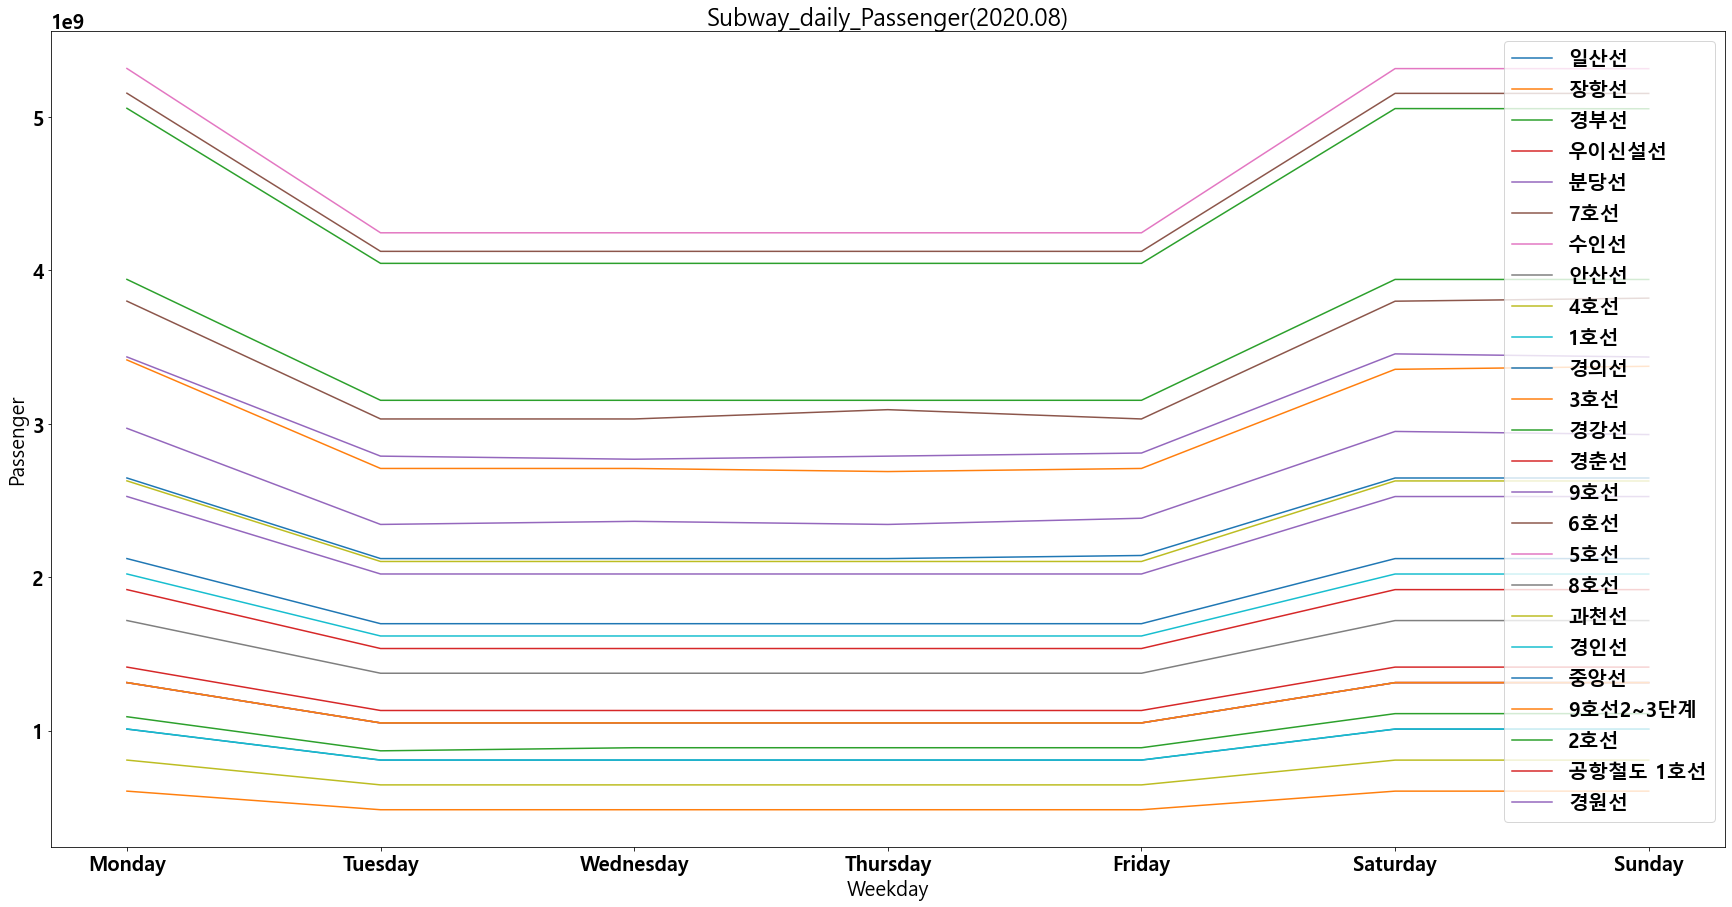

In [6]:
#5.
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

#topandas
pdf=maplines.toPandas()

#drop 'line' to make graph
my=pdf.drop('line', 1).transpose()

#reindex
my=my.reindex(index=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
#make graph
#columns
my.columns=['일산선','장항선','경부선','우이신설선','분당선','7호선','수인선','안산선','4호선','1호선','경의선','3호선','경강선','경춘선','9호선','6호선','5호선','8호선','과천선','경인선','중앙선','9호선2~3단계','2호선','공항철도 1호선','경원선']

#font
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
font = {'family' : font_name, 'weight' : 'bold', 'size'   : 20}
rc('font',**font)

#make lines
plt.rcParams['figure.figsize'] = [30, 15]
my.plot(title='Subway_daily_Passenger(2020.08)',kind='line',xlabel='Weekday',ylabel='Passenger')

## 문제2: 한국의 코로나바이러스

### 답 1. DataFrame 생성하고, 자동인식한 스키마를 출력

In [7]:
#1.
import os
corna = spark.read\
        .options(header ='true', inferschema ='true', delimiter=',')\
        .csv(os.path.join('data','TimeProvince.csv'))
#corna.show()
corna.printSchema()

root
 |-- date: string (nullable = true)
 |-- time: integer (nullable = true)
 |-- province: string (nullable = true)
 |-- confirmed: integer (nullable = true)
 |-- released: integer (nullable = true)
 |-- deceased: integer (nullable = true)



### 답 2. 3월의 데이터만 출력

In [8]:
#2.
_corna=corna.withColumn('year',corna.date.substr(0,4)).withColumn('month',corna.date.substr(6,2))
_corna_3=_corna.filter(_corna['month']=='03')
_corna_3.drop('month').drop('year').show()

+----------+----+-----------------+---------+--------+--------+
|      date|time|         province|confirmed|released|deceased|
+----------+----+-----------------+---------+--------+--------+
|2020-03-01|  16|            Seoul|       87|      11|       0|
|2020-03-01|  16|            Busan|       83|       0|       0|
|2020-03-01|  16|            Daegu|     2704|       6|      11|
|2020-03-01|  16|          Incheon|        6|       1|       0|
|2020-03-01|  16|          Gwangju|        9|       2|       0|
|2020-03-01|  16|          Daejeon|       13|       0|       0|
|2020-03-01|  16|            Ulsan|       20|       0|       0|
|2020-03-01|  16|           Sejong|        1|       0|       0|
|2020-03-01|  16|      Gyeonggi-do|       89|       8|       1|
|2020-03-01|  16|       Gangwon-do|       15|       0|       0|
|2020-03-01|  16|Chungcheongbuk-do|       11|       0|       0|
|2020-03-01|  16|Chungcheongnam-do|       68|       0|       0|
|2020-03-01|  16|     Jeollabuk-do|     

### 답 3. 년x월별 건수

In [9]:
#3.
_corna.groupBy('year').pivot('month').count().show()

+----+---+---+---+---+---+---+
|year| 01| 02| 03| 04| 05| 06|
+----+---+---+---+---+---+---+
|2020|204|493|527|510|527|510|
+----+---+---+---+---+---+---+



### 답 4. 도별 첫 확진자 출현 (모든 도 출력)

In [10]:
#4.
from pyspark.sql.functions import row_number

#confirmend==1 filter
corna_f=corna.filter(corna.confirmed==1)

#Using window function to make partition by province
#row_number makes us to find the first confirmed.
win = Window.partitionBy("province").orderBy("confirmed")
_corna_f=corna_f.withColumn("row_number", row_number().over(win))

#filter if row_number == 1
corna_1=_corna_f.filter(_corna_f.row_number=='1')

corna_1.drop('row_number').show()

+----------+----+-----------------+---------+--------+--------+
|      date|time|         province|confirmed|released|deceased|
+----------+----+-----------------+---------+--------+--------+
|2020-02-22|  16|           Sejong|        1|       0|       0|
|2020-02-22|  16|            Ulsan|        1|       0|       0|
|2020-02-21|  16|Chungcheongbuk-do|        1|       0|       0|
|2020-02-04|  16|          Gwangju|        1|       0|       0|
|2020-02-18|  16|            Daegu|        1|       0|       0|
|2020-01-20|  16|          Incheon|        1|       0|       0|
|2020-02-21|  16|          Jeju-do|        1|       0|       0|
|2020-01-24|  16|      Gyeonggi-do|        1|       0|       0|
|2020-01-27|  16|            Seoul|        1|       0|       0|
|2020-02-21|  16|Chungcheongnam-do|        1|       0|       0|
|2020-01-31|  16|     Jeollabuk-do|        1|       0|       0|
|2020-02-22|  16|     Jeollanam-do|        1|       0|       0|
+----------+----+-----------------+-----

### 답 5. 도별 누적 확진자 (마지막 일 6월 30일 기준, 모든 도 출력)

In [11]:
#5.
#partition by province
winAgg = Window.partitionBy("province")

#sum confirmed
ccdf=corna.withColumn("sulmulative_confirmed", F.sum(F.col("confirmed")).over(winAgg))

#filter 2020-06-30
ccdf.filter(ccdf["date"]=="2020-06-30").show()

+----------+----+-----------------+---------+--------+--------+---------------------+
|      date|time|         province|confirmed|released|deceased|sulmulative_confirmed|
+----------+----+-----------------+---------+--------+--------+---------------------+
|2020-06-30|   0|           Sejong|       50|      47|       0|                 5111|
|2020-06-30|   0|            Ulsan|       55|      50|       1|                 5269|
|2020-06-30|   0|Chungcheongbuk-do|       65|      60|       0|                 5801|
|2020-06-30|   0|       Gangwon-do|       65|      54|       3|                 5908|
|2020-06-30|   0|          Gwangju|       44|      32|       0|                 3359|
|2020-06-30|   0| Gyeongsangbuk-do|     1389|    1328|      54|               161079|
|2020-06-30|   0|            Daegu|     6906|    6700|     189|               807506|
|2020-06-30|   0| Gyeongsangnam-do|      134|     128|       0|                13860|
|2020-06-30|   0|          Incheon|      341|     290|

## 문제3: 키, 몸무게 상관관계

### 답 1. DataFrame 생성하고, 스키마를 출력

In [12]:
#1.
from pyspark.sql.types import *
rdd_hw=spark.sparkContext\
    .textFile(os.path.join('data','ds_spark_heightweight.txt'))\
    .map(lambda x:x.split())
hwDf = spark.createDataFrame(rdd_hw)

#change Schema
hwDf=hwDf.withColumn("id",hwDf['_1'].cast("string"))\
    .withColumn("height",hwDf['_3'].cast("double"))\
    .withColumn("weight",hwDf['_2'].cast("double"))

#drop previous column
hwDf = hwDf.drop('_1').drop('_2').drop('_3')

hwDf.printSchema()

root
 |-- id: string (nullable = true)
 |-- height: double (nullable = true)
 |-- weight: double (nullable = true)



### 답 2. BMI 컬럼 생성

In [13]:
#2.
#function to calculate BMI
BMI_f=udf(lambda t,w: w/((t/100)**2))

#add BMI column
hwDf.withColumn("BMI",BMI_f(hwDf['height'],hwDf['weight']).cast("double")).show()

+---+------+------+------------------+
| id|height|weight|               BMI|
+---+------+------+------------------+
|  1|112.99| 65.78| 51.52450781072923|
|  2|136.49| 71.52|38.390682967727116|
|  3|153.03|  69.4|29.635094329636853|
|  4|142.34| 68.22|33.671137797596444|
|  5| 144.3| 67.79| 32.55614482225709|
|  6| 123.3|  68.7| 45.18877660760553|
|  7|141.49|  69.8|34.866144799069374|
|  8|136.46| 70.01| 37.59666682483652|
|  9|112.37|  67.9| 53.77358764760977|
| 10|120.67| 66.78|45.861450799045116|
| 11|127.45| 66.49|40.933290095532044|
| 12|114.14| 67.62| 51.90383289772084|
| 13|125.61|  68.3|43.288473608554604|
| 14|122.46| 67.12| 44.75725444277766|
| 15|116.09| 68.28| 50.66451505225453|
| 16| 140.0| 71.09|36.270408163265316|
| 17| 129.5| 66.46|39.629701405763186|
| 18|142.97| 68.65| 33.58541408508863|
| 19| 137.9| 71.23| 37.45712255888467|
| 20|124.04| 67.13| 43.63079557093283|
+---+------+------+------------------+
only showing top 20 rows



### 답 3. weigth와 height의 Zscore 컬럼 생성

In [14]:
#3.
#calculate mean and stddev
_markStats = hwDf.select(
    F.mean('weight').alias('meanW'),
    F.stddev('weight').alias('stddevW'),
    F.mean('height').alias('meanH'),
    F.stddev('height').alias('stddevH')
).collect()

meanMark_W = _markStats[0]['meanW']
stdMark_W = _markStats[0]['stddevW']

meanMark_H = _markStats[0]['meanH']
stdMark_H = _markStats[0]['stddevH']

#calculate zscore for Weight and height
zscoreUdfW = F.udf(lambda x: (x-meanMark_W)/stdMark_W, DoubleType())
zscoreUdfH = F.udf(lambda x: (x-meanMark_H)/stdMark_H, DoubleType()) 

#add for column
hwDf=hwDf.withColumn("zscoreW", zscoreUdfW(hwDf['weight']))\
            .withColumn("zscoreH", zscoreUdfH(hwDf['height']))

hwDf.show()

+---+------+------+--------------------+--------------------+
| id|height|weight|             zscoreW|             zscoreH|
+---+------+------+--------------------+--------------------+
|  1|112.99| 65.78| -1.2458467531235724| -1.2298965504184058|
|  2|136.49| 71.52|  1.9011169693413281|  0.5933793097148594|
|  3|153.03|  69.4|  0.7388237478037734|    1.87665517042142|
|  4|142.34| 68.22| 0.09188695468380685|  1.0472586195778204|
|  5| 144.3| 67.79|-0.14386119874126027|  1.1993275849336167|
|  6| 123.3|  68.7| 0.35504768408853965|-0.42998275816419484|
|  7|141.49|  69.8|  0.9581243556410441|  0.9813103437857668|
|  8|136.46| 70.01|   1.073257174755618|  0.5910517235104339|
|  9|112.37|  67.9|-0.08355353158600981| -1.2779999986431976|
| 10|120.67| 66.78| -0.6975952335303837| -0.6340344820854917|
| 11|127.45| 66.49| -0.8565881742124118|-0.10799999988534137|
| 12|114.14| 67.62| -0.2370639570721033| -1.1406724125820966|
| 13|125.61|  68.3|   0.135747076251261| -0.2507586204234355|
| 14|122

### 답 4. spark에서 위에 계산한 zscore를 사용하여 상관관계 계산

In [15]:
#4.
#Using above calculation
import numpy as np

#convert to array
zscoreW=np.array(hwDf.select('zscoreW').collect())
zscoreH=np.array(hwDf.select('zscoreH').collect())

#calculate zscore correlation
zscore_cdf=(sum(zscoreW * zscoreH))/len(zscoreW)

print(zscore_cdf)

[0.58067169]


In [16]:
#Using scipy.stats
import scipy.stats as stats

#convert to array
weight=np.array(hwDf.select('weight').collect())
height=np.array(hwDf.select('height').collect())

print(sum (stats.zscore(weight) * stats.zscore(height))/len(weight))

[0.59252213]


### 답 5. scipy를 사용하여 상관관계를 계산

In [17]:
#5.
import scipy.stats as stats
#calculate 
stats.spearmanr(weight,height)

SpearmanrResult(correlation=0.5261110712457925, pvalue=8.707798759901837e-05)